# 2023-lab1-intro-to-dynamic-ircuits

## 1. 事前学習

###  1.1. 動的回路（Dynamic Circuit）とは？

IBMが無償公開している量子コンピューターの教材である[Qiskitテキストブック](https://ja.learn.qiskit.org/course/ch-algorithms/quantum-circuits)によると以下のように表現されています。
>_「量子回路とは、量子データ(量子ビットなど)に対するコヒーレントな量子演算と、リアルタイム同時古典計算で構成される計算ルーチンのことです。量子回路は、量子ゲート 、測定 、リセットの順序立てられたシーケンスであり、これらはすべてリアルタイム古典計算のデータを使用した条件付ゲートが作用することがあります。」_


この定義の最後の部分はあまり聞き慣れないかもしれませんが、これは動的回路に関係するものです。通常量子回路の話をするときは、明示的に言わないまでも静的な量子回路を指しています。では、動的回路とは何でしょうか？

動的回路とは、量子回路の途中で測定が行われ、その測定結果をもとに回路内の量子ゲートを条件付けることができる回路です。このように、古典的な測定結果をもとに将来の量子演算を条件付ける機能を古典フィードフォワードと呼びます。

なぜ古典フィードフォワードが必要なのでしょうか？

例として、Qiskitの条件付きリセット操作を考えてみましょう。
[`reset`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.reset.html)操作を使ったことがある人なら聞き覚えがあるかもしれません。

- 通常のリセット操作は、量子ビットをゼロ状態（つまり |0⟩ 状態）に戻す操作です。これは、量子ビットがどのような状態であっても、強制的に |0⟩ 状態に戻します。これは、非ユニタリー操作と呼ばれ、任意のユニタリー操作によって量子ビットを変化させた後、その逆のユニタリー操作を適用することで、量子ビットを元の状態に戻すこができるユニタリ性を持ちません。
- 条件付きリセット操作は、このプロセスを少し変えます。まず、量子ビットを測定します。その測定結果に基づいて、もし量子ビットが 1 状態（つまり |1⟩ 状態）にあれば、ビットフリップXゲート（これは量子ビットの状態を反転させる操作）を適用して、量子ビットを |0⟩ 状態に戻します。しかし、量子ビットがすでに |0⟩ 状態の場合は、何もしません。

この条件付きリセットの利点は、すでに測定された情報を活用して、より効率的かつエラーが少ない方法で量子ビットを初期状態に戻すことができる点です。回路にすると以下のイメージになります。

<center>
<img src="resources/sketch-1.png" width="50%">
</center>

別の言い方をすれば動的回路は、量子計算における「if文」や「whileループ」のような制御構造を含んだ量子回路です。これらの制御構造は、過去に測定された量子ビットの結果に基づいて条件を決定します。そして、条件に応じて特定の量子ゲート（量子ビットの状態を変化させる操作）が適用されます。このように、ダイナミック回路では量子ビットの測定結果に基づいて、回路の動作が動的に変化することが特徴です。

### 1.2. 簡単なハンズオン

手始めに、この機能を使った簡単な例を確認しましょう。次の手順で、条件付きリセット回路を作ることにします。

1. 1量子ビットと2古典ビットで回路を初期化する。($q_{0}$、$b_{0}$、$b_{1}$)
2. $q_{0}$にアダマールゲートを適用する。
3. その量子ビットを測定し、その結果を$b_{0}$に保存する。
4. $b_{0}$が1の場合`if_test`ブロックを開始する。
5. `if_test`ブロックの中で条件を満たした場合に行う操作を指定する。（今回は$q_{0}$を0状態に反転させます。）
6. 再度$q_0$を$b_{1}$に測定し、常に結果が0となることを確認する。

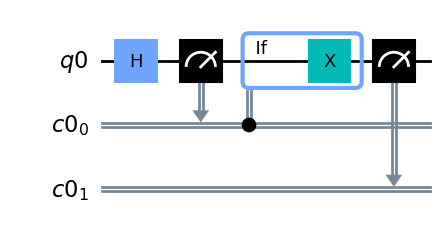

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister

# 1量子ビットと2古典ビットを持つ量子・古典レジスターと回路を準備
qr = QuantumRegister(1)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)

# レジスターから量子ビットと古典ビットを取り出す
(q0,) = qr
b0, b1 = cr

# q0にアダマールゲートを適用して重ね合わせ状態を作る
qc.h(q0)

# q0を測定し、その結果をb0に保存する
qc.measure(q0, b0)

# q0の測定結果が1の場合、条件付きでXゲートを適用し、q0を反転する
with qc.if_test((b0, 1)):
    qc.x(q0)

# もう一度q0を測定し、その結果をb1に保存する
qc.measure(q0, b1)

# 回路を描画（アイドル状態の量子ビットのワイヤを除外）
qc.draw(output="mpl", idle_wires=False)

回路ができたので何度か動かしてみて常に期待通りの出力が得られるかどうか確認してみましょう。最初の測定は0でも1でも構いませんが、2回目の測定は必ず0になるはずです。

In [2]:
from qiskit_aer import AerSimulator

# AerSimulatorを使用して量子回路のシミュレータを初期化
backend_sim = AerSimulator()

# 事前に定義された量子回路をシミュレータで実行
reset_sim_job = backend_sim.run(qc)

# 実行した回路の結果を取得
reset_sim_result = reset_sim_job.result()

# 結果からビット文字列のカウント（量子状態の出現頻度）を取得
reset_sim_counts = reset_sim_result.get_counts()

# カウントの結果を表示
print(f"カウント: {reset_sim_counts}")

カウント: {'00': 527, '01': 497}


期待通り最初のビットは0になったり1になったりしますが、2番目のビットは常に0です。（Qiskitはリトルエンディアンのビット順を採用しているので、右端のビットが1番目のビット、左端のビットが最後のビットになることを思い出してください。）

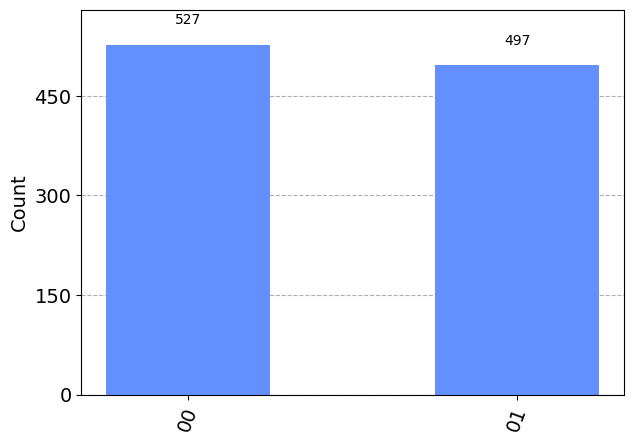

In [3]:
from qiskit.visualization import *

# ヒストグラムを作成
plot_histogram(reset_sim_counts)

## 2. 問題解説

### **Exercise 1**: 2量子ビットの動的回路

レベルを上げましょう。最初の課題は2量子ビットの動的回路を設計することです。この場合$q_{0}$の値によって$q_{1}$に異なる動作をさせることが目的となります。$q_{0}$の測定値が0なら$q_{1}$に$X$ゲートを適用します。1であれば代わりに$q_{1}$にアダマールゲートを適用します。

$q_{0}$の値をランダムにするために、まずアダマールゲートを適用します。次に、$q_{0}$を測定して$b_{0}$に書き込みます。そうすると、動的なマジックが起こるはずです。最後に$q_{1}$を測定します。

解答は以下のようになります。 [`if_test()`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.if_test.html) を読むと使い方がわかります。

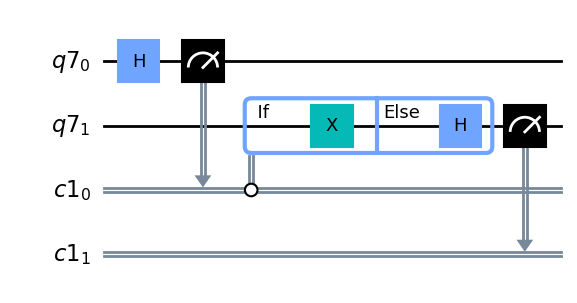

In [4]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

# 2量子ビットと2古典ビットの量子レジスタと古典レジスタを作成
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)

# レジスタから量子ビットと古典ビットを取り出す
q0, q1 = qr
b0, b1 = cr

# q0にアダマールゲートを適用し、重ね合わせ状態を作成
qc.h(q0)
# q0を測定し、結果を古典ビットb0に保存
qc.measure(q0, b0)

########## your code goes here #######

# b0が0の場合、q1にXゲートを適用する条件分岐を開始
with qc.if_test((b0, 0)) as else_:
    qc.x(q1)
# b0が0でない場合（つまり1の場合）、q1にアダマールゲートを適用するelseブロック
with else_:
    qc.h(q1)

# q1を測定し、結果を古典ビットb1に保存
qc.measure(q1, b1)

# 回路を描画（使用されていないワイヤは表示しない）
qc.draw(output="mpl", idle_wires=False)


以下で実行し、回路が期待通りに動作するかをチェックします。

In [5]:
from qiskit_aer import AerSimulator

# AerSimulatorをインポートし、シミュレータのインスタンスを作成
backend_sim = AerSimulator()

# 回路をシミュレータで実行し、ジョブを作成
job_1 = backend_sim.run(qc)
# ジョブから結果を取得
result_1 = job_1.result()
# 結果からカウント（測定値の分布）を取得
counts_1 = result_1.get_counts()

# カウントを表示
print(f"Counts: {counts_1}")

Counts: {'10': 533, '11': 255, '01': 236}


この動的回路の結果を説明します。

1. **初期状態**: 2量子ビット(q0, q1)は初期状態 `|00⟩` からスタートします。

2. **アダマールゲート**: q0にHゲート（アダマールゲート）を適用すると、q0の状態は重ね合わせ状態 `(1/√2)(|0⟩ + |1⟩)` になります。これにより、全体の状態は `(1/√2)(|00⟩ + |01⟩)` となります。

3. **q0の測定と条件分岐**: 
   - q0を測定した結果が `0` の場合（確率 50%）、条件分岐によりq1にXゲートが適用され、状態は `|01⟩` になります。
   - q0を測定した結果が `1` の場合（確率 50%）、elseブロックによりq1にアダマールゲートが適用され、q1の状態は `(1/√2)(|0⟩ + |1⟩)` になり、全体の状態は `(1/√2)(|01⟩ + |11⟩)` となります。

4. **最終状態**: 
   - q0が `0` である確率は 50%、その場合q1は `1` になります（'10'）。
   - q0が `1` である確率は 50%、その場合q1は `0` または `1` になる可能性が等しく（'01', '11'）、それぞれ25%の確率で発生します。

したがって、最終的なビット文字列のカウントは、'01'が最も多く（50%）、次に'01'と'11'がほぼ同数（それぞれ約25%）となります。実際の結果はこの理論的な確率と近似しますが、量子シミュレータのランダム性や測定の誤差により、正確な数字は異なることがあります。

以下でヒストグラムにして確認してみましょう。上記の説明通りになるはずです。

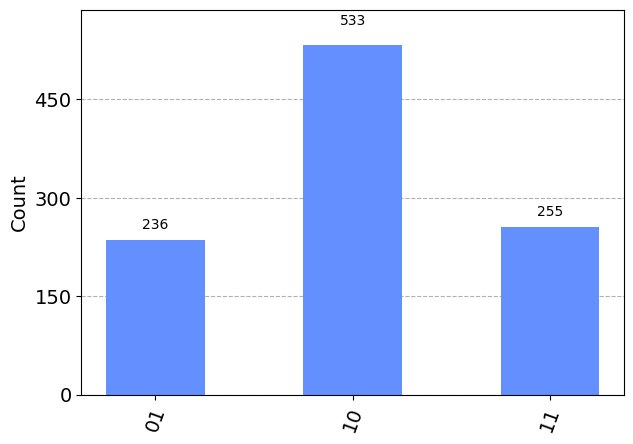

In [6]:
from qiskit.visualization import *

# ヒストグラムを作成
plot_histogram(counts_1)

### **Exercise 2**: 成功するまで繰り返す動的回路（1/3）

量子コンピューティングでは、プロセスの出力がランダムであり、いつも望んだ結果が得られるとは限りません。しかし、望む結果を得る確率が少しでもあれば、プロセスを繰り返すことで、最終的にはその結果が得られます。多くの場合、何回か試すだけで望んだ結果にたどり着けます。

このセクションでは、望んだ結果を得るまでプロセスを繰り返す方法を使って、特定の量子ゲート $R_X(\theta)$（ここで $\theta / \pi$ は無理数）を、限られたゲートセット $\{H, X, S, \text{Toffoli}\}$ から構築します。特に $\cos\theta = \frac35$ の場合に焦点を当てます。この方法は、限られたゲートセットがどのようにして多様な操作を行えるかを示します。

各ゲートの概要は以下です。
- H（アダマールゲート）: 量子ビットを重ね合わせ状態に変換します。
- X（パウリ-Xゲート）: 量子ビットの状態を反転させます（0 から 1 へ、またはその逆）。
- S（位相ゲート）: 量子ビットの位相（波の形）を変更します。
- Toffoli（トフォリゲート、または制御制御NOTゲート）: トマソ・トフォリによって提案された可逆論理ゲートです。3量子ビットを利用する演算で、2つのコントロールビットと1つのターゲットビットを持っています。2つのコントロールビットが両方1の時にのみ、ターゲットビットを反転させます。

このゲートを構築するには、3つの量子ビットに作用する回路を作ります。このプロセスを管理するためには、動的回路が必要です。
- 1つは目的の量子ビットで、ここに $R_X(\theta)$ ゲートを適用します。
- 残りの2つは「シンドローム」量子ビットと呼ばれ、操作が成功したかどうかを測定するのに使います。
  - もし両方のシンドローム量子ビットが `0` であれば、ゲートが成功したと判断できます。
  - そうでなければ、量子ビットをリセットしてもう一度試します。


このセクションの最初の課題は、上記の回路を返す関数を作成することです。回路のアウトプットイメージはこちらです。

<center>
<img src="resources/circuitRx.png">
</center>

簡単にできるように、必要な要素を入れた「ベース」回路を用意してあります。このLabで書く関数は、回路を入力として受け取りその場で修正するものです。新しい回路が必要なときはベースとなる回路のコピーを作ればよいのです。

In [7]:
# 2量子ビットからなる「制御」用の量子レジスタを作成
controls = QuantumRegister(2, name="control")

# 1量子ビットからなる「ターゲット」用の量子レジスタを作成
target = QuantumRegister(1, name="target")

# 中間測定用の2ビットの古典レジスタを作成
mid_measure = ClassicalRegister(2, name="mid")

# 最終測定用の1ビットの古典レジスタを作成
final_measure = ClassicalRegister(1, name="final")

# 上記のレジスタを使用して量子回路のベースを作成
base = QuantumCircuit(controls, target, mid_measure, final_measure)

次のセルでは、特定の量子回路を構築するための `trial` 関数を定義します。この関数では、以下のステップに従って回路が構成されます。

1. 制御レジスターの各量子ビットとターゲット量子ビットにアダマールゲートを適用します。これにより、これらの量子ビットは重ね合わせ状態になります。
2. 制御レジスターとターゲット量子ビットの間にトフォリ（制御-制御-NOT）ゲートを適用します。これは、ターゲット量子ビットに対する条件付きの反転操作を行います。
3. ターゲット量子ビットに $S$ ゲートを適用します。これにより、ターゲット量子ビットの位相が変化します。
4. 再び、同じ制御レジスターとターゲット量子ビットに対してトフォリゲートを適用します。
5. 制御レジスターとターゲットレジスターに再びアダマールゲートを適用します。
6. 最後に、制御レジスターの量子ビットを測定し、その結果を古典レジスターに記録します。

この関数は、特定の条件下でターゲット量子ビットに $R_x(\theta)$ 操作を行う確率的なプロセスを実現します。


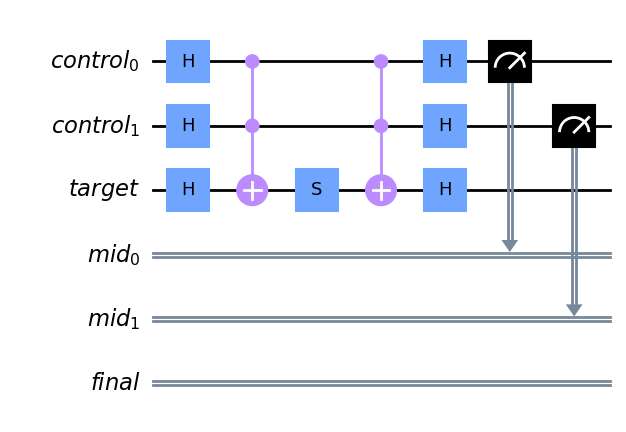

In [8]:
def trial(
    circuit: QuantumCircuit,
    target: QuantumRegister,
    controls: QuantumRegister,
    measures: ClassicalRegister,
):
    """Probabilistically perform Rx(theta) on the target, where cos(theta) = 3/5."""

    ########## your code goes here #######

    # ターゲットと制御レジスターの量子ビットにアダマールゲートを適用
    circuit.h(target)
    circuit.h(controls)

    # 制御レジスターとターゲットビットでトフォリゲートを適用
    circuit.ccx(*controls, target)

    # ターゲット量子ビットにSゲートを適用
    circuit.s(target)

    # 再度、同じ制御レジスターとターゲットビットでトフォリゲートを適用
    circuit.ccx(*controls, target)

    # 制御レジスターとターゲットレジスターにアダマールゲートを再適用
    circuit.h(controls)
    circuit.h(target)

    # 制御レジスターを測定し、結果を古典レジスターに記録
    circuit.measure(controls, measures)


# 回路の初期状態をコピーして新しい回路を作成
qc = base.copy_empty_like()

# 定義したtrial関数を使用して、回路に操作を追加
trial(qc, target, controls, mid_measure)

# 回路を描画
qc.draw("mpl", cregbundle=False)

### **Exercise 3**: 成功するまで繰り返す動的回路（2/3）

次のステップでは、私たちは量子回路での操作が計画通りに進んだかを確認します。

- 制御ビットの測定結果が両方 $|0\rangle$ だと、目的の操作が正しく行われたと理解できます。
- しかし、制御ビットの測定結果が一つでも $|1\rangle$ になると、回路は予定とは異なる単純な操作を行ったとみなされ、それは操作が失敗したことを意味します。

この結果から、目的の操作を正しく適用できたかどうかを確認できます。もし失敗していた場合、量子ビットを初期状態に戻して、もう一度試す必要があります。失敗した時にどの操作が行われたかがわかるので、その情報を利用して効率的にリセットすることができます。すなわち、2つの補助量子ビットについては、それぞれの測定値が $1$ であることを条件として、 $X$ ゲートを適用すれば良いのです。

次のセルに`reset_controls`関数の中身を埋めて、次のステップで回路を変更できるようにしてください。

1. `measures`レジスターの最初のビットが1の場合、最初の制御量子ビットに$X$ゲートを適用する。
2. `measures`レジスターの2番目のビットが1の場合、2番目の制御量子ビットに$X$ゲートを適用する。

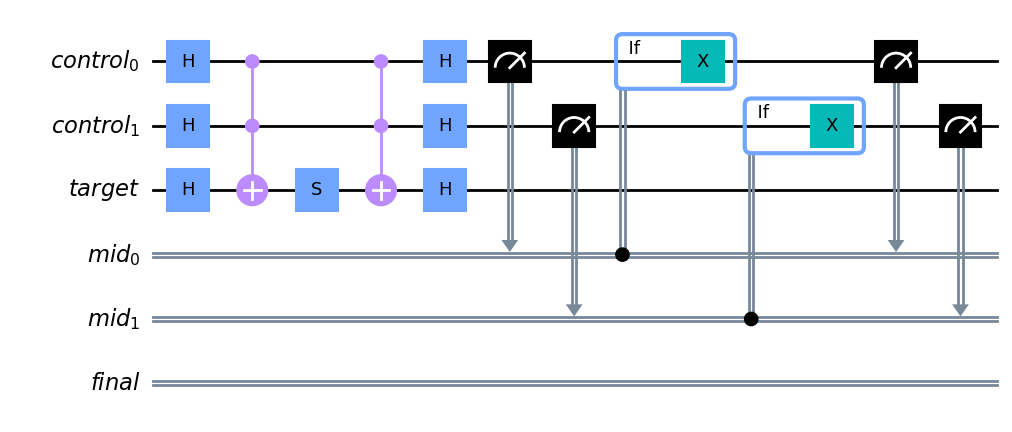

In [9]:
def reset_controls(
    circuit: QuantumCircuit, controls: QuantumRegister, measures: ClassicalRegister
):
    """Reset the control qubits if they are in |1>."""

    ########## your code goes here #######

    # measuresレジスターの最初のビットが1の場合、最初の制御量子ビットにXゲートを適用
    with circuit.if_test((measures[0], True)):
        circuit.x(controls[0])

    # measuresレジスターの2番目のビットが1の場合、2番目の制御量子ビットにXゲートを適用
    with circuit.if_test((measures[1], True)):
        circuit.x(controls[1])


# 回路の初期状態をコピーして新しい回路を作成
qc = base.copy_empty_like()

# 定義したtrial関数を使用して、回路に操作を追加
trial(qc, target, controls, mid_measure)

# 定義したreset_controls関数を使用して、制御量子ビットをリセット
reset_controls(qc, controls, mid_measure)

# 制御レジスターを測定し、結果を古典レジスターに記録
qc.measure(controls, mid_measure)

# 回路を描画
qc.draw("mpl", cregbundle=False)

あとは、条件が満たされなかった場合に、回路の実行を繰り返すだけです。
最後のExerciseでは、現在の動的回路のサポートにおける2つの問題点を解決する必要があります。

最初の問題は、Qiskitが現在、古典ビットに対するいかなる算術・論理演算の実行もサポートしていないことです。特に古典レジスターが特定の値を持って*いない*ことをチェックする機能はサポートしていません。現状、回路途中の測定値がビット列`00`で*ない*場合のみ、試行を繰り返す必要があります。この問題を回避するために、測定値が `00` に等しいことを条件とする if 文を作成し、空のブロックを**パス**して、**else** 分岐を使用して測定値が `00` でない場合に必要な論理を実行することになります。

2つ目の問題は、現在、私たちのハードウェアがループをサポートしていないことです。そのため、真の意味で成功するまで繰り返すループを実行することができません。そこで、この問題を解決するために、試行回路を一定回数だけ繰り返すことにします。

### **Exercise 4**: 成功するまで繰り返す動的回路（3/3）

以下のコードセルに、シンドローム量子ビットの測定で試行を繰り返す必要があると判断された場合に実行されるロジックを `else` ブロックに記入してください。

1. ターゲット量子ビットをゼロ状態にリセットする。（すでに1の状態であることを知っていることを思い出してください）
2. 回路上の `trial` 関数を再び呼び出す。

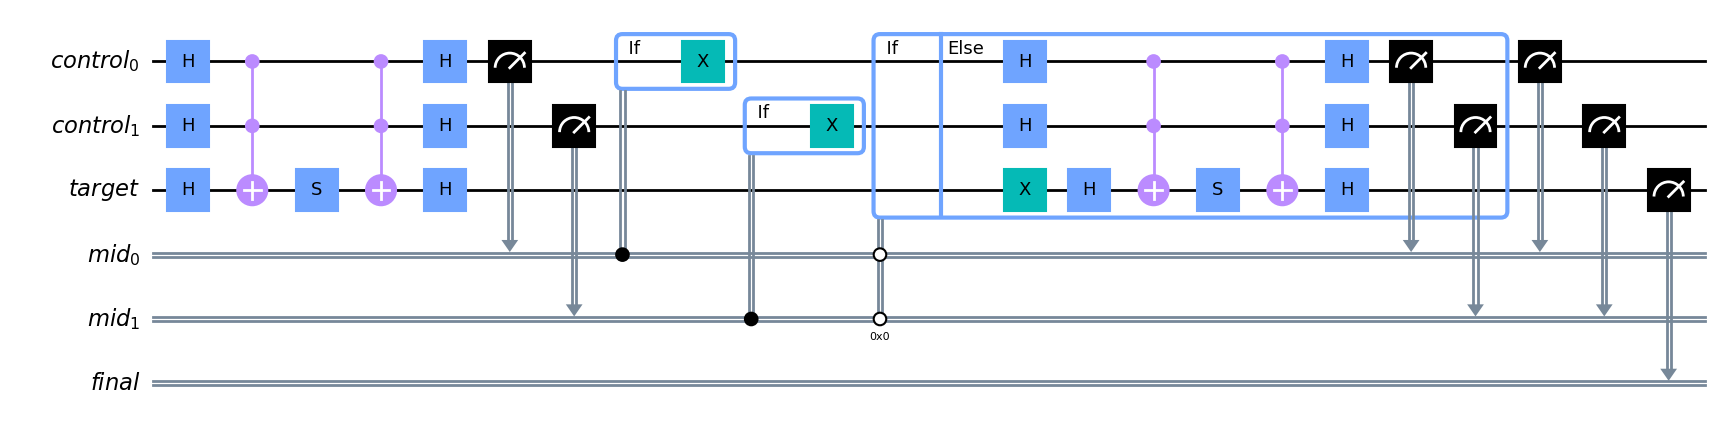

In [10]:
# 最大試行回数を設定
max_trials = 2

# 最初に設定した基盤回路と同じ構造（ビット、レジスタなど）のクリーンな回路を作成
circuit = base.copy_empty_like()

# 最初の試行では、制御ビットが必ず |0> 状態から始まるため、リセットは不要
trial(circuit, target, controls, mid_measure)

# 手動で残りの試行を追加。将来的には動的な `while` ループを使用できるようになるが、
# 現在は各ループの繰り返しを手動で追加し、各試行に手動で条件チェックを行う。
# これには `while` ループよりも多くの古典的同期が必要だが、今のところはこれで十分。
for _ in range(max_trials - 1):
    reset_controls(circuit, controls, mid_measure)
    with circuit.if_test((mid_measure, 0b00)) as else_:
        # これは成功パスですが、Qiskitはまだ否定条件を直接表現できないため、
        # `else` ブランチを使用するために空の `true` ブロックがあります。
        pass
    with else_:
        ####### your code goes here #######

        # まずターゲットをリセット
        circuit.x(target)
        # 次にtrialを繰り返す
        trial(circuit, target, controls, mid_measure)

# 制御ビットを再度測定して、最終結果を得る必要があります。これはハードウェアの制限です。
circuit.measure(controls, mid_measure)

# 最後に、目的の回転を得ているか確認するためにターゲットを測定します。
circuit.measure(target, final_measure)

# 回路を描画
circuit.draw("mpl", cregbundle=False)


シミュレーター上で回路を実行しましょう。

Counts: {'1 11': 48, '1 01': 49, '1 10': 49, '0 00': 680, '1 00': 174}


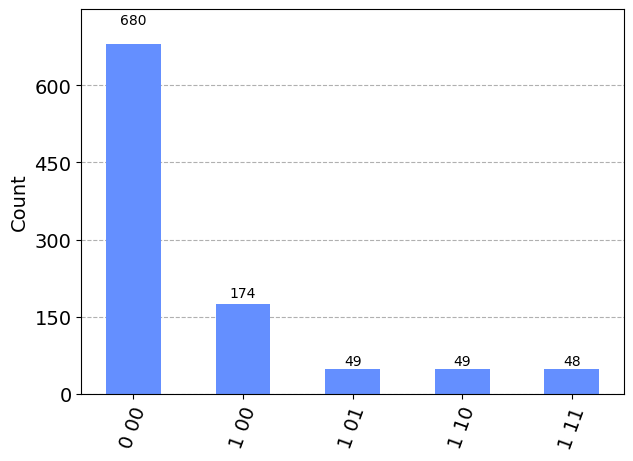

In [11]:
# Aerのシミュレーターをインスタンス化
sim = AerSimulator()

# シミュレーターで回路を実行し、1000ショット（試行回数）でジョブを送信
job = sim.run(circuit, shots=1000)

# ジョブの結果を取得
result = job.result()

# 測定結果のカウント（各量子状態が観測された回数）を取得
counts = result.get_counts()

# カウントを表示
print(f"Counts: {counts}")

# カウントのヒストグラムをプロット
plot_histogram(counts)

この量子回路のシミュレーション結果 `例) Counts: {'1 00': 181, '1 11': 41, '1 10': 40, '1 01': 40, '0 00': 698}` について説明します。結果は、1000回の試行（ショット）における異なる量子ビットの状態の観測回数を表しています。

- `'0 00': 698` は、最も一般的な結果で、制御ビットが両方 $|0\rangle$ でターゲットビットも $|0\rangle$ と測定された回数です。これは、回路が目的とする操作を正しく遂行したことを意味する可能性が高いです。

- `'1 00': 181` は、制御ビットが両方 $|0\rangle$ でターゲットビットが $|1\rangle$ と測定された回数です。これは、目的の操作後にターゲットビットが反転された状態です。

- `'1 11': 41`, `'1 10': 40`, `'1 01': 40` は、ターゲットビットが $|1\rangle$ で、少なくとも一方の制御ビットが $|1\rangle$ と測定された場合です。これは操作が失敗したことを示しており、ターゲットビットには単純な $X$ ゲートの作用と同等の効果があったと考えられます。

動的回路の概念では、回路の実行中に測定を行い、その結果に基づいて回路の次のステップを決定します。この回路では、制御ビットの測定によって回路が成功したか失敗したかを判断し、失敗した場合にはリセットして再試行するプロセスを含んでいます。このように動的回路は、量子回路の柔軟性と能力を高め、より複雑な量子アルゴリズムを可能にする強力なツールです。
